<a href="https://colab.research.google.com/github/bibekebib/The-worst-DL-model-/blob/main/10_Monkey_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bibekchalise","key":"4085de002b360174d7ceaf9f1c3a974a"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species

 97% 529M/547M [00:03<00:00, 193MB/s]
100% 547M/547M [00:03<00:00, 150MB/s]


In [ ]:
!unzip 10-monkey-species.zip
import os
os.remove('/content/10-monkey-species.zip')

Archive:  10-monkey-species.zip
  inflating: monkey_labels.txt       
  inflating: training/training/n0/n0018.jpg  
  inflating: training/training/n0/n0019.jpg  
  inflating: training/training/n0/n0020.jpg  
  inflating: training/training/n0/n0021.jpg  
  inflating: training/training/n0/n0022.jpg  
  inflating: training/training/n0/n0023.jpg  
  inflating: training/training/n0/n0024.jpg  
  inflating: training/training/n0/n0025.jpg  
  inflating: training/training/n0/n0026.jpg  
  inflating: training/training/n0/n0027.jpg  
  inflating: training/training/n0/n0028.jpg  
  inflating: training/training/n0/n0029.jpg  
  inflating: training/training/n0/n0030.jpg  
  inflating: training/training/n0/n0031.jpg  
  inflating: training/training/n0/n0032.jpg  
  inflating: training/training/n0/n0033.jpg  
  inflating: training/training/n0/n0034.jpg  
  inflating: training/training/n0/n0035.jpg  
  inflating: training/training/n0/n0036.jpg  
  inflating: training/training/n0/n0037.jpg  
  inflatin

In [ ]:
!ls

kaggle.json  monkey_labels.txt	sample_data  training  validation


In [ ]:
trn_data_folder = '/content/training/training'
val_data_folder = '/content/validation/validation'

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch.nn as nn
!pip install torch_summary
from torchvision import transforms, models, datasets
from torch.optim import Adam, SGD
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

def GetCSV(name, folder):
  import pandas as pd
  img  = pd.DataFrame(glob.glob(folder+'/*/*'), columns=['imgpath'])
  labels = []
  for i in range(len(glob.glob(folder+'/*/*'))):
    labels.append((glob.glob(folder+'/*/*')[i].split('/')[-2]))
  label = pd.DataFrame(labels, columns=['label'])
  df = pd.merge(img, label, left_index=True, right_index=True)
  return df.to_csv(name+'.csv')

GetCSV('train', trn_data_folder)
GetCSV('test', val_data_folder)

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.loc[49]

Unnamed: 0                                         49
imgpath       /content/training/training/n7/n7147.jpg
label                                              n7
Name: 49, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


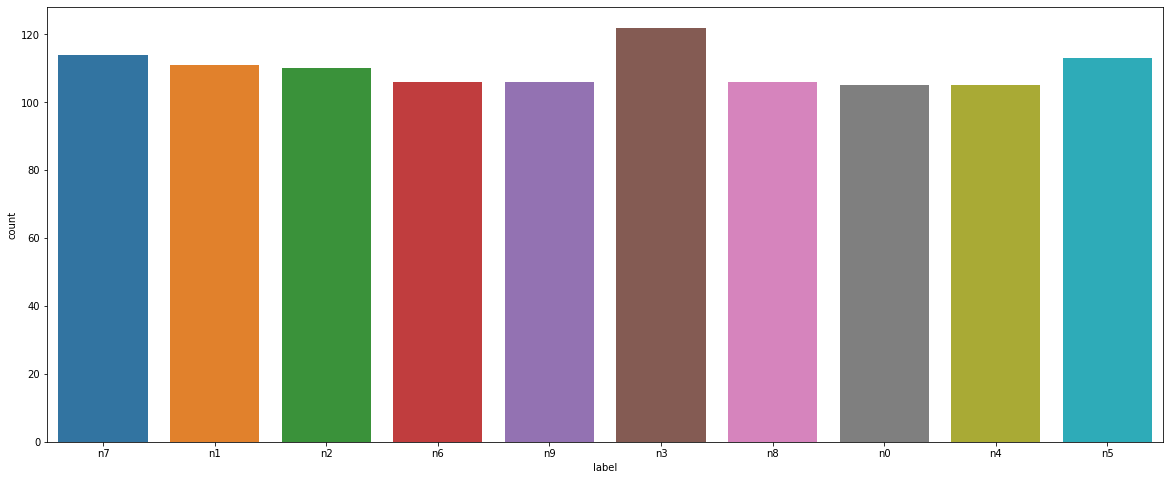

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,8))
sns.countplot(df['label'])
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder()
df.label = labels.fit_transform(df.label)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


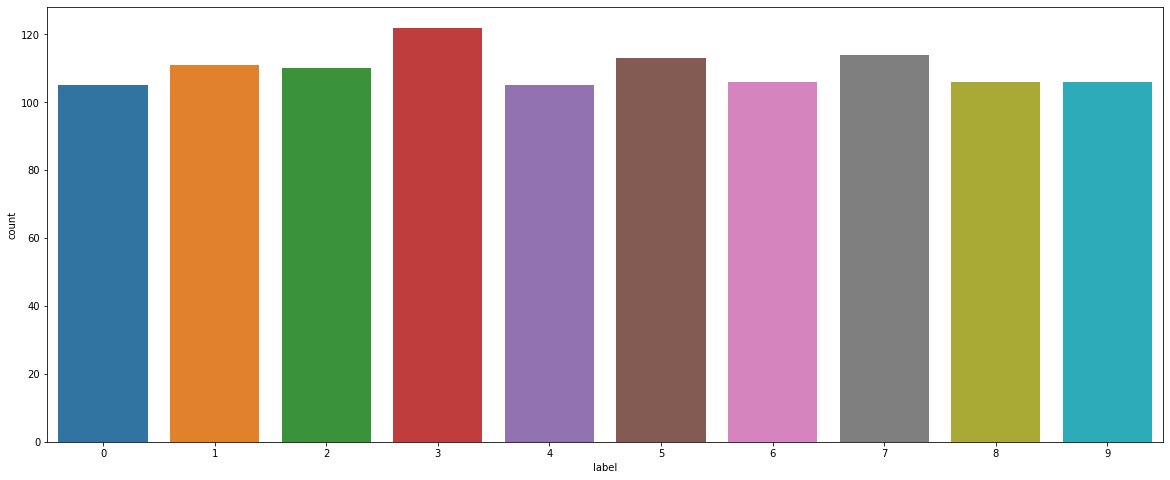

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df['label'])
plt.show()

In [ ]:
for label in df.label:
  if label == 'n8':
    print (label)
  else:
    pass

In [ ]:
class MonkeyDataset(Dataset):
  def __init__(self, file):
    df = pd.read_csv(file)
    labels = LabelEncoder()
    df.label = labels.fit_transform(df.label)
    self.fpaths = df.imgpath
    self.targets = df.label
  
  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
 
        f = self.fpaths[ix]
        target = (self.targets[ix])
        im = cv2.imread(f)[:,:,::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor(target).long().to(device)


In [ ]:
data = MonkeyDataset('train.csv')

In [ ]:
im, label = data[100]

tensor(7, device='cuda:0')


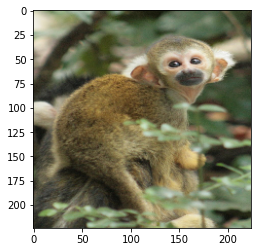

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [ ]:
def get_model():
  model = nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      conv_layer(512,512,3),
      nn.Flatten(),
      nn.Linear(512,10),
      nn.Sigmoid(),
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [ ]:
def get_data():
  train = MonkeyDataset('train.csv')
  trn_dl = DataLoader(train, batch_size=32,shuffle=True, drop_last=True)
  val = MonkeyDataset('test.csv')
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [30]:
@torch.no_grad()
def accuracy(x, y, model):
  prediction = model(x)
  is_correct = (prediction > 0.5) ==1
  return is_correct.cpu().numpy().tolist()

In [31]:
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [32]:
trn_dl, val_dl  = get_data()
model, loss_fn, optimizer = get_model()

In [35]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        #print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        #validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    #val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


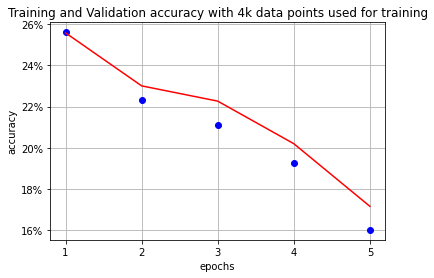

In [36]:
epochs = np.arange(5) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy with 4k data points used for training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()